## Import packages

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import KFold
from sklearn import preprocessing

## Data Collection

In [42]:
class Collection:
    def parse_total_charges(total_charges_arr):
        """
        Takes total charges and gets rid of NaN values
        All NaN's are associated with customers who have just started service
        Set value to zero
        Input:
            total_charges_arr: nparray of total charges
        Output:
            total_charges_arr: nparray of total charges (without NaNs)
        """
        for idx in range(0,len(total_charges_arr)):
            if np.isnan(total_charges_arr[idx]):
                total_charges_arr[idx] = 0
        return total_charges_arr

    def parse_total_internetService(internetService_arr):
        """
        Takes type of internet service and assigns a score
        Fiber optic is the highest end, score of 10
        DSL is the lower end, score of 3
        No internet gets a score of 0
        Input:
            internetService_arr: nparray of internet service type
        Output:
            internetService_arr: nparray of internet service score
        """
        for idx in range(0,len(internetService_arr)):
                if internetService_arr[idx] == "DSL":
                    thisVal = 1
                elif internetService_arr[idx] == "Fiber optic":
                    thisVal = 2
                elif internetService_arr[idx] == "No":
                    thisVal = 0
                else:
                    print("Contract length not specified properly")
                internetService_arr[idx] = thisVal
        return internetService_arr

    def parse_total_contract(contract_arr):
        """
        Takes contract length (string) and returns numerica value
        Input:
            contract_arr: nparray of contract length (string)
        Output:
            contract_arr: nparray of contract length (float)
        """
        for idx in range(0,len(contract_arr)):
                if contract_arr[idx] == "Month-to-month":
                    thisVal = 1/12
                elif contract_arr[idx] == "One year":
                    thisVal = 1
                elif contract_arr[idx] == "Two year":
                    thisVal = 2
                else:
                    print("Contract length not specified properly")
                contract_arr[idx] = thisVal
        return contract_arr

    def parse_telecom_data_drop(filename_train,filename_test, entry_to_delete):
        '''
        Takes filename and returns data after applying label encoding and OneHotEncoding
        Removes one column of data

        Input:
            filename_train: name of CSV file for train data
            filename_test: name of CSV file for test data
            entry_to_delete: index of column to delete
        Output:
            X_train: nparray of X train data
            Y_train: nparray of labels for train data
            X_train: nparray of X test data
            ID_test: nparray of customer ID for test data
            c2drop: label of column that has been dropped

        '''
        X_train_in = pd.read_csv(filename_train)
        X_test_in = pd.read_csv(filename_test)

        X_train_in = X_train_in.fillna(0)
        X_test_in = X_test_in.fillna(0)

        n_entries = len(X_train_in.columns)

        if (entry_to_delete > (n_entries - 3)):
            print('out of deletion range')
        elif entry_to_delete < 0:
            c2drop = '';
        else:
            cols = X_train_in.columns
            c2drop = cols[entry_to_delete+1]
            print('column to delete ', c2drop)
            X_train_in.drop(columns=[c2drop], inplace=True)
            X_test_in.drop(columns=[c2drop], inplace=True)

        # get customer ID for test data
        ID_test = X_test_in[['customerID']].to_numpy()

        # get X with categorical data
        removeData_list = ['customerID','tenure','InternetService','Contract','MonthlyCharges','TotalCharges']
        if c2drop in removeData_list:
            removeData_list = [i for i in removeData_list if i != c2drop]
        X_train_cat = X_train_in.drop(columns=removeData_list)
        X_test_cat = X_test_in.drop(columns=removeData_list)

        # get X with numeric data
        numData_list = ['tenure','MonthlyCharges','TotalCharges']
        if c2drop in numData_list:
            numData_list = [i for i in numData_list if i != c2drop]
        X_train_num = X_train_in[numData_list].to_numpy()
        X_test_num = X_test_in[numData_list].to_numpy()

        # handle total charges
        if c2drop != 'TotalCharges':
            idx = len(numData_list) - 1;
            X_train_num[:,idx] = CollectionDrop.parse_total_charges(X_train_num[:,idx])
            X_test_num[:,idx] = CollectionDrop.parse_total_charges(X_test_num[:,idx])

        # handle contract length
        if c2drop != 'Contract':
            X_train_contract = X_train_in[['Contract']].to_numpy()
            X_test_contract = X_test_in[['Contract']].to_numpy()
            X_train_contract = CollectionDrop.parse_total_contract(X_train_contract)
            X_test_contract = CollectionDrop.parse_total_contract(X_test_contract)
            X_test_num = np.concatenate((X_test_num, X_test_contract), axis=1)
            X_train_num = np.concatenate((X_train_num, X_train_contract), axis=1)

        # handle internet service type
        if c2drop != 'InternetService':
            X_train_internetService = X_train_in[['InternetService']].to_numpy()
            X_test_internetService = X_test_in[['InternetService']].to_numpy()
            X_train_internetService = CollectionDrop.parse_total_internetService(X_train_internetService)
            X_test_internetService = CollectionDrop.parse_total_internetService(X_test_internetService)
            X_test_num = np.concatenate((X_test_num,X_test_internetService), axis=1)
            X_train_num = np.concatenate((X_train_num, X_train_internetService), axis=1)

        # get Y
        X_train_cat = X_train_cat.drop(columns=['Discontinued'])
        Y_train_cat = X_train_in.filter(['Discontinued'])

        # convert labels to numeric using LabelEncoder
        le = preprocessing.LabelEncoder()
        colList = X_train_cat.columns
        ncol_le = len(colList)
        m_train_rows = X_train_cat.shape[0]
        m_test_rows = X_test_cat.shape[0]
        X_train_le = np.zeros((m_train_rows,ncol_le))
        X_test_le = np.zeros((m_test_rows,ncol_le))
        for jdx in range(0,ncol_le):
            le.fit(X_train_cat[colList[jdx]])
            X_train_le[:,jdx] = le.transform(X_train_cat[colList[jdx]])
            X_test_le[:,jdx] = le.transform(X_test_cat[colList[jdx]])

        # get labels for training data
        Y_train = Y_train_cat.apply(le.fit_transform)
        Y_train = Y_train.to_numpy()

        # use OneHotEncoder (applied to encoded labels)
        enc = preprocessing.OneHotEncoder()
        enc.fit(X_train_le)
        X_train_ohl = enc.transform(X_train_le).toarray()
        X_test_ohl = enc.transform(X_test_le).toarray()

        # combine data
        n_ohl = X_train_ohl.shape[1]
        n_num = X_train_num.shape[1]
        X_train = np.zeros((m_train_rows,n_ohl+n_num))
        X_test = np.zeros((m_test_rows,n_ohl+n_num))
        X_train[:,0:n_ohl] = X_train_ohl
        X_test[:,0:n_ohl] = X_test_ohl
        X_train[:,n_ohl:] = X_train_num
        X_test[:,n_ohl:] = X_test_num

        return X_train,Y_train,X_test,ID_test,c2drop

    def parse_telecom_data(filename_train,filename_test):
        '''
        Takes filename and returns data after applying label encoding and OneHotEncoding

        Input:
            filename_train: name of CSV file for train data
            filename_test: name of CSV file for test data
        Output:
            X_train: nparray of X train data
            Y_train: nparray of labels for train data
            X_train: nparray of X test data
            ID_test: nparray of customer ID for test data
        '''
        X_train,Y_train,X_test,ID_test = Collection.parse_telecom_data_drop(filename_train,filename_test,-1)[0:4];
        return X_train,Y_train,X_test,ID_test

class CollectionDrop(Collection):
    def parse_telecom_data(filename_train, filename_test,entry_to_delete):
        return Collection.parse_telecom_data_drop(filename_train, filename_test,entry_to_delete);

## Identify important features
Remove features and examine effect on test and validation error

column to delete  gender
column to delete  SeniorCitizen
column to delete  Partner
column to delete  Dependents
column to delete  tenure
column to delete  PhoneService
column to delete  MultipleLines
column to delete  InternetService
column to delete  OnlineSecurity
column to delete  OnlineBackup
column to delete  DeviceProtection
column to delete  TechSupport
column to delete  StreamingTV
column to delete  StreamingMovies
column to delete  Contract
column to delete  PaperlessBilling
column to delete  PaymentMethod
column to delete  MonthlyCharges
column to delete  TotalCharges


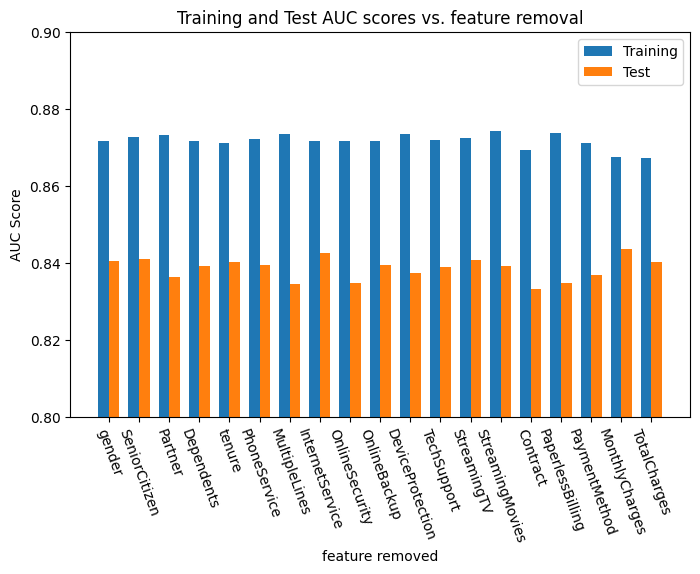

In [43]:
# AdaBoost case study
n_to_test = 19
col_list = []
vals = {}
avg_train_metric = np.zeros((n_to_test,))
avg_val_metric = np.zeros((n_to_test,))

for i in range(n_to_test):
    n_folds = 2
    kf = KFold(n_splits=n_folds, shuffle=True)
    [X_train,Y_train,X_test,ID_test,col] = CollectionDrop.parse_telecom_data(filename_train='train.csv',filename_test='test.csv',entry_to_delete=i)
    train_Metric = 0
    val_Metric = 0
    for train_idx, val_idx in kf.split(X_train[:,0]):
        x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
        y_train, y_val = Y_train[train_idx], Y_train[val_idx]

        clf = AdaBoostClassifier(n_estimators=200, learning_rate=0.55)
        clf.fit(x_train, y_train.flatten())

        y_train_prob = clf.predict_proba(x_train)
        thisMetric = metrics.roc_auc_score(y_train, y_train_prob[:,1])
        train_Metric += thisMetric

        y_train_prob = clf.predict_proba(x_val)
        thisMetric = metrics.roc_auc_score(y_val, y_train_prob[:,1])
        val_Metric += thisMetric

    avg_train_metric[i] = train_Metric/n_folds
    avg_val_metric[i] = val_Metric/n_folds
    col_list.append(col)

vals['Training'] = avg_train_metric
vals['Test'] = avg_val_metric
x = np.arange(len(col_list))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(figsize=(8,5))

for attribute, measurement in vals.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    multiplier += 1
ax.set_ylim([.8,.9])
ax.set_ylabel('AUC Score')
ax.set_xlabel('feature removed')
ax.set_title('Training and Test AUC scores vs. feature removal')
ax.set_xticks(x + width/2, col_list,rotation=-70)

plt.legend()
plt.show()

In [44]:
## Getting order of importance
a = np.where(avg_val_metric.flatten() > avg_val_metric[-1])

res = np.argsort(avg_val_metric)
print(res)
for i in range(len(res)):
    idx = len(res) - i - 1
    idx_2 = res[idx]
    print(col_list[idx_2])


[14  6 15  8  2 16 10 11 13  3  5  9  4 18  0 12  1  7 17]
MonthlyCharges
InternetService
SeniorCitizen
StreamingTV
gender
TotalCharges
tenure
OnlineBackup
PhoneService
Dependents
StreamingMovies
TechSupport
DeviceProtection
PaymentMethod
Partner
OnlineSecurity
PaperlessBilling
MultipleLines
Contract


## Adaboost case study
Identify best number of estimators and best learning rate

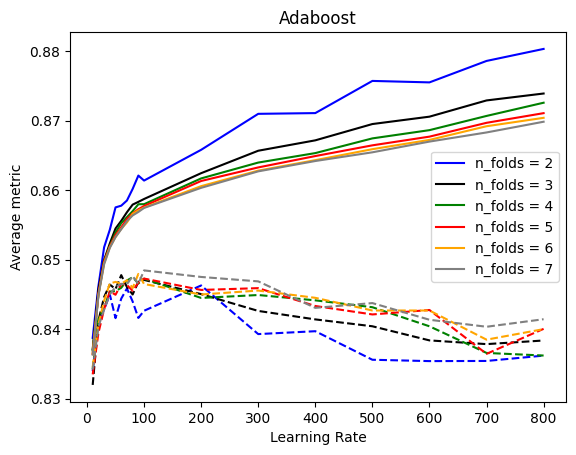

In [45]:
# load data
[X_train,Y_train,X_test,ID_test] = Collection.parse_telecom_data(filename_train='train.csv',filename_test='test.csv')

# AdaBoost case study
n_est_list = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200, 300, 400, 500, 600, 700, 800]
learn_rate_list = [200]
c = ['b', 'k', 'g', 'r', 'orange','gray']
n_list = [2,3,4,5,6,7]
fig, ax = plt.subplots()
for i,n_folds in enumerate(n_list):
    kf = KFold(n_splits=n_folds, shuffle=True)
    for lr in (learn_rate_list):
        avg_train_metric = np.zeros((len(n_est_list),))
        avg_val_metric = np.zeros((len(n_est_list),))
        avg_full_metric = np.zeros((len(n_est_list),))
        for j,n_est in enumerate(n_est_list):
            train_Metric = 0
            val_Metric = 0
            y_train_prob_avg = 0

            for train_idx, val_idx in kf.split(X_train[:,0]):
                x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
                y_train, y_val = Y_train[train_idx], Y_train[val_idx]

                clf = AdaBoostClassifier(n_estimators=lr, learning_rate=n_est/800)
                clf.fit(x_train, y_train.flatten())

                y_train_prob = clf.predict_proba(x_train)
                thisMetric = metrics.roc_auc_score(y_train, y_train_prob[:,1])
                train_Metric += thisMetric

                y_train_prob = clf.predict_proba(x_val)
                thisMetric = metrics.roc_auc_score(y_val, y_train_prob[:,1])
                val_Metric += thisMetric

                y_train_prob = clf.predict_proba(X_train)
                y_train_prob_avg += y_train_prob[:,1]

            avg_train_metric[j] = train_Metric/n_folds
            avg_val_metric[j] = val_Metric/n_folds
            avg_full_metric[j] = metrics.roc_auc_score(Y_train, y_train_prob_avg/n_folds)

        ax.plot(n_est_list,avg_train_metric, color=c[i], label=f'n_folds = {n_folds}')
        ax.plot(n_est_list,avg_val_metric, color=c[i], linestyle='--')

ax.set_xlabel('Learning Rate')
ax.set_ylabel('Average metric')
plt.title('Adaboost')

plt.legend()
plt.show()

## AdaBoost Demonstration
Build final AdaBoost model

In [46]:
[X_train,Y_train,X_test,ID_test] = Collection.parse_telecom_data(filename_train='train.csv',filename_test='test.csv');

n_folds = 5
kf = KFold(n_splits=n_folds)
i = 0
train_Metric = 0
val_Metric = 0
y_train_prob_avg = 0
y_test_prob_avg = 0

featureList = ["tenure","MonthlyCharges","Total Charges","Contract","InternetService","gender",
               "Senior Citizen","Partner","Dependents","PhoneService","MultipleLines","OnlineSecurity","OnlineBackup",
               "DeviceProtection","TechSupport","StreamingTV","StreamingMovies","PaperlessBilling","PaymentMethod"];
importanceArr = np.zeros((len(featureList),n_folds));

for train_idx, val_idx in kf.split(X_train[:,0]):
    print(f'--------------- k-fold {i} ---------------')
    x_train, x_val = X_train[train_idx,:], X_train[val_idx,:]
    y_train, y_val = Y_train[train_idx], Y_train[val_idx]

    clf = AdaBoostClassifier(n_estimators=200, learning_rate=0.55)
    clf.fit(x_train, y_train.flatten())

    y_prob = clf.predict_proba(x_train)
    thisMetric = metrics.roc_auc_score(y_train, y_prob[:,1])
    train_Metric += thisMetric
    print("Training metric: ",thisMetric)

    y_prob = clf.predict_proba(x_val)
    thisMetric = metrics.roc_auc_score(y_val, y_prob[:,1])
    val_Metric += thisMetric
    print("Testing metric: ",thisMetric)

    y_train_prob = clf.predict_proba(X_train)
    y_train_prob_avg += y_train_prob[:,1]

    y_test_prob = clf.predict_proba(X_test)
    y_test_prob_avg += y_test_prob[:,1]
    print(' ')

    importances = clf.feature_importances_;
    importanceArr[0,i] = importances[0];
    importanceArr[1,i] = importances[1];
    importanceArr[2,i] = importances[2];
    importanceArr[3,i] = importances[3];
    importanceArr[4,i] = importances[4];
    importanceArr[5,i] = sum(importances[5:7]);
    importanceArr[6,i] = sum(importances[7:9]);
    importanceArr[7,i] = sum(importances[9:11]);
    importanceArr[8,i] = sum(importances[11:13]);
    importanceArr[9,i] = sum(importances[13:15]);
    importanceArr[10,i] = sum(importances[15:18]);
    importanceArr[11,i] = sum(importances[18:21]);
    importanceArr[12,i] = sum(importances[21:24]);
    importanceArr[13,i] = sum(importances[24:27]);
    importanceArr[14,i] = sum(importances[27:30]);
    importanceArr[15,i] = sum(importances[30:33]);
    importanceArr[16,i] = sum(importances[33:36]);
    importanceArr[17,i] = sum(importances[36:38]);
    importanceArr[18,i] = sum(importances[38:42]);

    i += 1

print(f'Average training metric: {train_Metric/n_folds}')
print(f'Average testing metric: {val_Metric/n_folds}')
thisMetric = metrics.roc_auc_score(Y_train, y_train_prob_avg/n_folds)
print(f'Full training metric: {thisMetric}')

# write prediction to file
y_test_prob = y_test_prob_avg/n_folds
thisData = np.concatenate((ID_test, np.reshape(y_test_prob,(-1,1))), axis=1)
thisLabel = ['ID','TARGET']
y_test_prob_pd = pd.DataFrame(data=thisData,columns=thisLabel)
fname_submit = 'test_submission_Ethan.csv'
y_test_prob_pd.to_csv(fname_submit,index=False)

--------------- k-fold 0 ---------------
Training metric:  0.8659412716096984
Testing metric:  0.8468412653712568
 
--------------- k-fold 1 ---------------
Training metric:  0.861392560582952
Testing metric:  0.8595707998729639
 
--------------- k-fold 2 ---------------
Training metric:  0.8664652349256236
Testing metric:  0.841431480295917
 
--------------- k-fold 3 ---------------
Training metric:  0.8700047627623342
Testing metric:  0.8255358041103765
 
--------------- k-fold 4 ---------------
Training metric:  0.8618047826032693
Testing metric:  0.8584433429847377
 
Average training metric: 0.8651217224967755
Average testing metric: 0.8463645385270503
Full training metric: 0.8621421283616327


## Feature importance
Get importance from AdaBoost feature_importances_

In [47]:
importances = clf.feature_importances_
importanceVec = np.mean(importanceArr,axis=1);
idx_sort = np.argsort(importanceVec);
thisN = len(featureList);
for idx in range(0,10):
    thisIdx = idx_sort[thisN-idx-1];
    print(featureList[thisIdx] + ": ",importanceVec[thisIdx]);

PaymentMethod:  0.7180000000000001
PaperlessBilling:  0.164
MultipleLines:  0.022
Partner:  0.017
StreamingTV:  0.016
StreamingMovies:  0.012
OnlineBackup:  0.012
TechSupport:  0.009
Contract:  0.006
PhoneService:  0.006
